In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import copy
import subprocess
from funcs import *
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
from IPython.display import display, Javascript
import time
import hashlib
import shelve
import subprocess
import os

def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
        
    if (os.path.exists(nc_file) or os.path.exists('./models/') or os.path.exists('./data/')) == False:
        raise ValueError('nc_file or target folder does not exist')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
                
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')
        
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    save_model = ["cp", "{}".format(nc_file), "./models/{}_{}.nc".format(branch_name, hashmark)]
    proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)

    bk = shelve.open('./data/{}_{}.pkl'.format(branch_name, hashmark),'n')
    exceptions = ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']
    for k in sorted(globals()):
        if k in exceptions:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [12]:
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

ice_temp = 268
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))

attrs = {#"ocean.always_grounded": "no",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [4]:
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 910.0             # [kg m-3]

Lx = 2 * 25e3  # in km
Ly = 2 * 25e3  # in km

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
topg = np.zeros((ny, nx))
tauc = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*268.15
precip = np.zeros((ny, nx))
land_ice_area_fraction_retreat = np.ones_like(topg)

'''
for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        # add 10k to topography to prevent floating ice
        tauc[i, j] = 1e5*(1000 + np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0))
        topg[i,j ] = np.maximum(500 *(1-(dist*2/Lx)), 0)
        precip[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = topg[i,j]+1
'''

base = np.ones((ny, nx)) * (x/10+5000)
bump = np.zeros((ny, nx))
tauc = np.ones((ny,nx))*5e7
for i in range(0,nx):
    for j in range(0, ny):
        bump[i,j] = 300*np.exp((-(y[j]+10000)**2)/(2*5000**2))
        if j<=24:
            tauc[i,j] -= 2e7*np.exp((-(x[i])**2)/(2*7000**2))
        dist = ((x[i])**2+(y[j]-15000)**2)**0.5
        precip[i, j] = 4 *(1-(dist*2/Lx))

        
topg = base + bump
thk = np.ones((ny,nx))
surf = topg+thk

Text(0.5, 1.0, 'surface velocity')

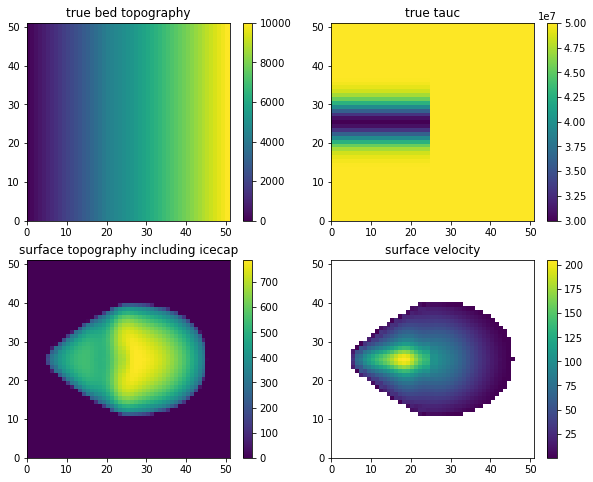

In [5]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
field = ax[0,0].pcolor(topg)
field1 = ax[0,1].pcolor(tauc)
field2 = ax[1,0].pcolor(get_nc_data('icecap_output.nc', 'thk', 0))
field3 = ax[1,1].pcolor(get_nc_data('icecap_output.nc', 'velsurf_mag', 0))

fig.colorbar(field, ax = ax[0,0])
fig.colorbar(field1, ax = ax[0,1])
fig.colorbar(field2, ax = ax[1,0])
fig.colorbar(field3, ax = ax[1,1])

ax[0,0].set_title('true bed topography')
ax[0,1].set_title('true tauc')
ax[1,0].set_title('surface topography including icecap')
ax[1,1].set_title('surface velocity')

In [6]:
##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 None,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 None,
                 topg],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             None,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  None,
                                  precip * ice_density],
        'land_ice_area_fraction_retreat' : ["1",
                                            "maximum ice extent mask",
                                            "",
                                            None,
                                            land_ice_area_fraction_retreat],
        'tauc': ['Pa',
                 'yield stress for basal till (plastic or pseudo-plastic model)',
                 'yield stress',
                 None,
                 tauc],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



In [7]:
def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

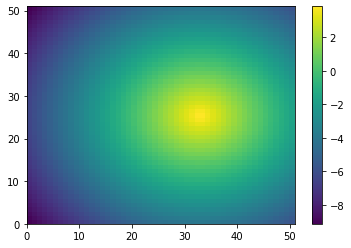

In [8]:
fig, axes = plt.subplots()
colors = plt.pcolor(precip, axes=axes)
fig.colorbar(colors)

In [16]:
def create_script(forward_or_iteration):
    print("""#!/bin/bash
    ###### run script for experiment icecap ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx 51 -My 51 -Mz 30 -Mbz 1 -Lz 20000 -Lbz 1 -grid.recompute_longitude_and_latitude false"')
    #print('PHYS="-stress_balance ssa+sia -ssa_flow_law isothermal_glen"')
    print('PHYS="-stress_balance blatter"')
    print('THERMAL="-energy none"')
    print('CONF="-config_override icecap_conf.nc"')

    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# create icecap"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag, uvel, vvel"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $SLIDING $THERMAL $CONF $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [17]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('icecap_build_script.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward')
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()

In [19]:
!chmod +x icecap_build_script.sh
!./icecap_build_script.sh 4 icecap_initialSetup.nc 5000 icecap_output.nc > icecap_output_log.txt

In [20]:
!tail icecap_output_log.txt

S 5000-10-30 03.442h:    0.00175    0.01040          0.03385        172.41029
Blatter solver: 695 * (5 - 1) = 2780 active elements
  Vertical spacing (m): min = 73.601, max = 202.589, avg = 146.221
  Aspect ratios:        min = 0.037, max = 0.101, avg = 0.073, max/min = 2.753
Blatter solver: CONVERGED_FNORM_RELATIVE. Done.
  SNES: 2, KSP: 94
vy$Eh  reporting (-extra_times) (overrides end of the run) (dt=0.17221)
S 5001-01-01 00.000h:    0.00175    0.01040          0.03385        172.41044
... done with run
Writing model state to file `icecap_output.nc'...


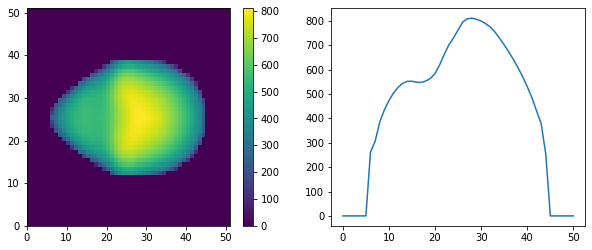

In [22]:
nc_data = get_nc_data('ex_icecap_output.nc', 'velbase_mag', -1)
nc_data2 = get_nc_data('ex_icecap_output.nc', 'thk', -2)
fig, axes = plt.subplots(1,2, figsize=(10,4))
colors = axes[0].pcolor(nc_data2)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(nx), nc_data2[25,:])

In [68]:
### bed recovery ###
S_ref = get_nc_data('icecap_output.nc', 'usurf', 0)
S_rec = copy.deepcopy(S_ref)

h_ref = get_nc_data('icecap_output.nc', 'thk', 0)
B_rec = copy.deepcopy(base)#np.minimum(S_ref - 1, np.ones_like(topg)*5000)
dh_ref = np.zeros_like(topg)#nc_data - nc_data2
B_init = copy.deepcopy(B_rec)

tauc_rec = np.ones_like(tauc)*5e7
tauc_init = copy.deepcopy(tauc_rec)
vel_ref = get_nc_data('icecap_output.nc', 'velsurf_mag', 0)
vel_rec = copy.deepcopy(vel_ref)

mask = get_nc_data('icecap_output.nc', 'mask', 0)/2

B_rec_all = []
dh_all = []
B_misfit_vs_iter = []
dh_misfit_vs_iter = []
tauc_rec_all = []
vel_all = []
tauc_misfit_vs_iter=[]
vel_misfit_vs_iter=[]
misfit_thk_all = []
misfit_fr_all = []
S_rec_all = []

pmax = 100
dt = 0.1
beta = 1
bw = 4
p_friction = 500

!cp icecap_output.nc icecap_iteration_out.nc
    
original_stdout = sys.stdout
with open('icecap_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration')
    sys.stdout = original_stdout
    f.close()
!cp icecap_iteration_out.nc icecap_iteration_in.nc
!chmod +x icecap_iteration_script.sh

In [69]:
for p in tqdm.trange(0, pmax):  
    
    h_old = S_rec - B_rec
    
    !cp icecap_iteration_out.nc icecap_iteration_in.nc
    #if p>0:
    #    mask = get_nc_data('icecap_iteration_in.nc', 'mask', 0)
    #    k = np.ones((bw+2, bw+2))
    #    buffer = ndimage.convolve(mask, k)/(bw+2)**2/2
    #    buffer[buffer>=.5] = 0
    #    buffer[buffer!=0] = (buffer[buffer!=0])*2
    #    B_rec -= (buffer) * np.mean(h_old) 
    #    h_old = S_ref - B_rec

    nc_updated = NC('icecap_iteration_in.nc', 'r+')
    nc_updated['tauc'][0,:,:]=tauc_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['topg'][0,:,:]=B_rec
    #nc_updated['climatic_mass_balance'][0,:,:]=np.maximum(nc_updated['climatic_mass_balance'][0:,:],0)
    nc_updated.close()
        
    cmd = ["./icecap_iteration_script.sh", '4', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
    
    vel_rec = get_nc_data('icecap_iteration_out.nc', 'velsurf_mag', 0)
    h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0)
    u[criterion] = 0
    v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0)
    v[criterion] = 0
    
    #misfit_fr = shift((vel_ref-vel_rec), u, v, .3)
    #misfit = shift((dh_rec-dh_ref), u, v, 0)
    misfit = dh_rec - dh_ref
    
    #misfit_lowpass = ndimage.gaussian_filter(misfit, 1)
    #misfit_highpass = misfit - misfit_lowpass
    
    #tauc_rec = tauc_rec - beta * (misfit_fr)*1e6
    B_rec = B_rec - beta * (misfit)
    #S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*.05) * misfit_highpass[np.logical_and(mask==1, h_rec>20)] 
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.02) * misfit[np.logical_and(mask==1, h_rec>20)] 

    '''

    H_rec = S_ref - B_rec
    B_rec = ndimage.gaussian_filter(H_rec, 1, truncate=1)
    B_rec = S_ref - H_rec
    '''
    ### buffer ###
    #B_rec[criterion]=0
    h_inpaint = S_rec - B_rec
    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    h_inpaint = inpaint_nans(h_inpaint)
    B_rec = S_rec - h_inpaint
    #tauc_rec[criterion]=1e8
    ### buffer end ###

    B_rec[mask==0] = S_ref[mask==0]
    B_rec[B_rec>S_rec] = S_rec[B_rec>S_rec]
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    tauc_rec[mask==0] = tauc[mask==0]
    tauc_rec_all.append(tauc_rec)
    vel_all.append(vel_rec)
    S_rec_all.append(S_rec)
    
    tauc_misfit_vs_iter.append(np.mean(abs(tauc_rec[mask==1]-tauc[mask==1])))
    vel_misfit_vs_iter.append(np.mean(abs(vel_rec[mask==1]-vel_ref[mask==1])))
    B_misfit_vs_iter.append(np.mean(abs(B_rec[mask==1]-topg[mask==1])))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))
    misfit[mask==0] = np.nan
    #misfit_fr_all.append(misfit_fr)
    #misfit_thk_all.append(misfit_thk)
    
    if p>0 and p%p_friction == 0:   

        vel_mismatch = np.maximum(np.minimum((vel_rec - vel_ref)/vel_ref, 0.5), -0.5)
        vel_mismatch[mask==0]=np.nan
        vel_mismatch =  gauss_filter(vel_mismatch, .6,2)
        vel_mismatch[np.isnan(vel_mismatch)]=0
        tauc_rec = tauc_rec+vel_mismatch* tauc_rec

 16%|███████████████████████████████▊                                                                                                                                                                       | 16/100 [01:01<11:02,  7.88s/it]--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[50901,1],0]
  Exit code:    1
--------------------------------------------------------------------------
 19%|█████████████████████████████████████▊                                                                                                      

KeyboardInterrupt: 

Text(0.5, 1.0, 'bed misfit after 200 iterations')

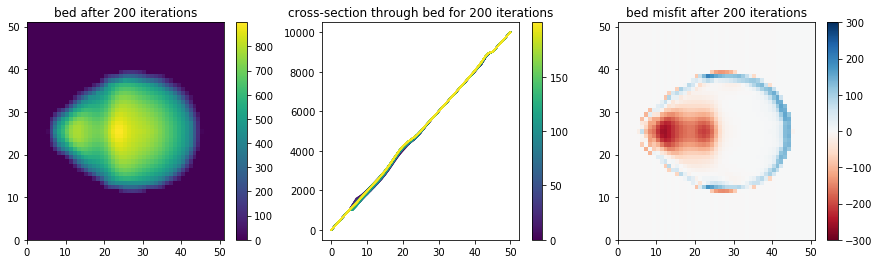

In [58]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(dh_all))]#len(tauc_rec_all))]
bounds=np.linspace(0,200, 1000)
norm = plt_colors.BoundaryNorm(bounds, colormap.N)
fig, axes = plt.subplots(1,3, figsize=(15,4))
field = axes[0].pcolor(S_ref - B_rec_all[200])#, vmin = 1e7, vmax = 1e8)
fig.colorbar(field, ax=axes[0])
for i in range(0,len(dh_all),10):
    lines = axes[1].plot(range(nx), B_rec_all[i][23,:], color=colors[i])

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = axes[1], ticks=range(0,200, 50))
field2 = axes[2].pcolor(B_rec_all[200]-topg, vmin = -300, vmax = 300, cmap='RdBu')
fig.colorbar(field2, ax = axes[2])

axes[0].set_title('bed after 200 iterations')
axes[1].set_title('cross-section through bed for 200 iterations')
axes[2].set_title('bed misfit after 200 iterations')

Text(0.5, 1.0, 'bed misfit after 1998 iterations')

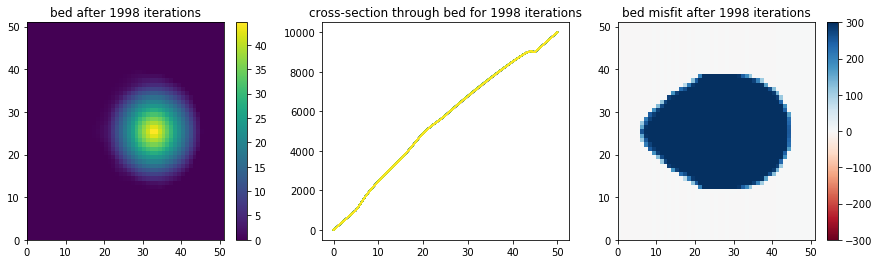

In [70]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0,1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
#norm = plt_colors.BoundaryNorm(bounds, colormap.N)
fig, axes = plt.subplots(1,3, figsize=(15,4))
field = axes[0].pcolor(S_ref - B_rec_all[-1])#, vmin = 1e7, vmax = 1e8)
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),1):
    lines = axes[1].plot(range(nx), B_rec_all[i][23,:], color=colors[i])

#cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = axes[1], ticks=range(0,2000, 300))
field2 = axes[2].pcolor(B_rec_all[-1]-topg, vmin = -300, vmax = 300, cmap='RdBu')
fig.colorbar(field2, ax = axes[2])

axes[0].set_title('bed after 1998 iterations')
axes[1].set_title('cross-section through bed for 1998 iterations')
axes[2].set_title('bed misfit after 1998 iterations')

Text(0.5, 0, 'iteration')

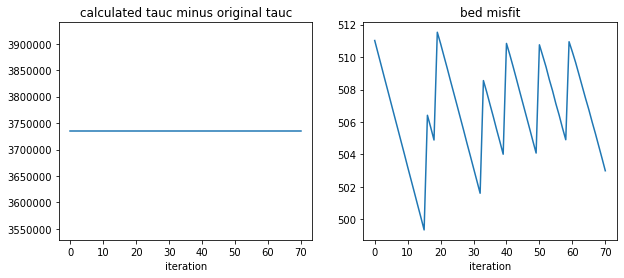

In [71]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(tauc_misfit_vs_iter)
ax[1].plot(B_misfit_vs_iter)

ax[0].set_title('calculated tauc minus original tauc')
ax[1].set_title('bed misfit')
ax[0].set_xlabel('iteration')
ax[1].set_xlabel('iteration')

Text(0.5, 1.0, 'cross-section through original tauc (brown),\n initial tauc guess (blue) and recovered tauc')

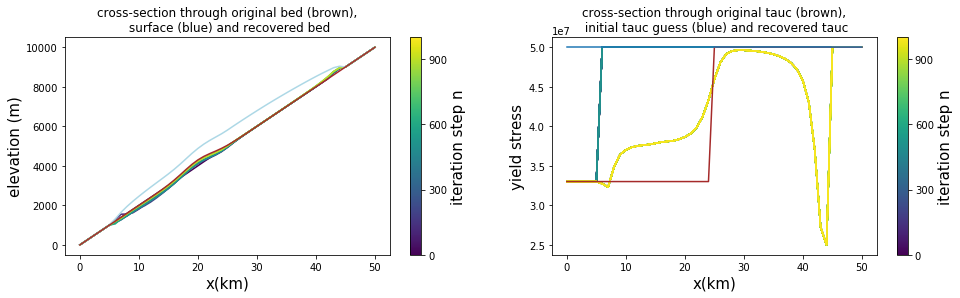

In [53]:
from matplotlib import colors as plt_colors

colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
norm = plt_colors.BoundaryNorm(bounds, colormap.N)

fig, ax = plt.subplots(1,2, figsize=(16,4))
for i in range(0,len(B_rec_all),100):
    lines = ax[0].plot(range(nx), B_rec_all[i][23,:], color=colors[i])
    #lines = ax[0].plot(range(nx), S_rec_all[i][:,25], color=colors[i])
lines2 = ax[0].plot(range(nx), S_ref[23,:], color = 'lightblue')
lines1 = ax[0].plot(range(nx), topg[23,:], color='brown')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[0], ticks=range(0,2000,300))
cbar.set_label('iteration step n', fontsize= 15)
ax[0].set_xlabel('x(km)', fontsize= 15)
ax[0].set_ylabel('elevation (m)', fontsize= 15)
#plt.savefig('./figures/icecap_crosssection.png', dpi = 400)

for i in range(0,len(tauc_rec_all),10):
    lines = ax[1].plot(range(nx), tauc_rec_all[i][23,:], color=colors[i])
lines2 = ax[1].plot(range(nx), tauc[23,:], color = 'brown')
lines1 = ax[1].plot(range(nx), tauc_init[23,:])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = ax[1], ticks=range(0,2000,300))
cbar.set_label('iteration step n', fontsize= 15)
ax[1].set_xlabel('x(km)', fontsize= 15)
ax[1].set_ylabel('yield stress', fontsize= 15)

ax[0].set_title('cross-section through original bed (brown),\n surface (blue) and recovered bed')
ax[1].set_title('cross-section through original tauc (brown),\n initial tauc guess (blue) and recovered tauc')

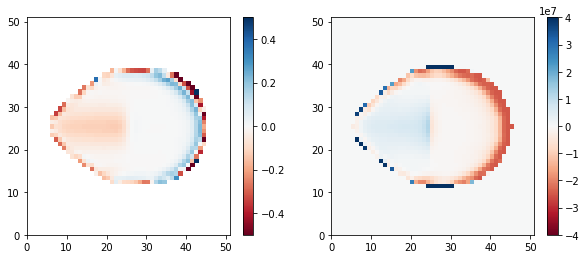

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
field = ax[0].pcolor((vel_rec - vel_ref)/vel_ref, vmin = -.5, vmax = .5, cmap='RdBu')
field1 = ax[1].pcolor((tauc_rec) - tauc, vmin = -4e7, vmax = 4e7, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

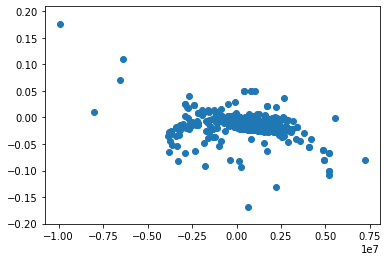

In [309]:
plt.scatter((tauc_rec_all[-1] - tauc)[np.logical_and(mask==1, criterion==0)], ((vel_all[-1] - vel_ref)/vel_ref)[np.logical_and(mask==1, criterion==0)])

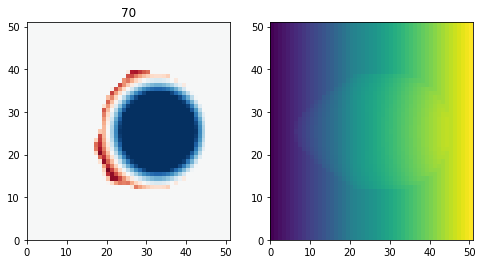

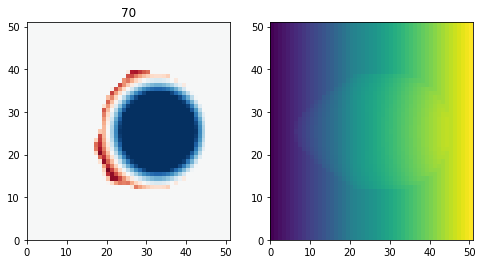

In [72]:
from IPython.display import display, clear_output
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(0,len(tauc_rec_all),2):
    field = axes[0].pcolor(dh_all[i], cmap='RdBu', vmin=-1, vmax=1)
    field = axes[1].pcolor(B_rec_all[i])
    axes[0].set_title(i)
    clear_output(wait=True)
    display(fig)

In [75]:
import random
rand_x = []
rand_y = []
rand_tauc = []
radar_mask = np.zeros_like(topg)
radar_bed = np.zeros_like(topg)
for i in range(1000):
    rand_x.append(random.choice(range(np.shape(topg)[0])))
    rand_y.append(random.choice(range(np.shape(topg)[1])))
    rand_tauc.append(tauc[rand_x[i], rand_y[i]])
    radar_mask[rand_x[i], rand_y[i]]=1
    radar_bed[rand_x[i], rand_y[i]]=topg[rand_x[i], rand_y[i]]

In [133]:
rad_msk = radar_mask[3:-3,3:-3]
rad_msk_nan = copy.deepcopy(rad_msk)
rad_msk_nan[rad_msk==0] = np.nan

#H = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'thk', 0)[1:-1,1:-1]
h = copy.deepcopy(S_ref)
H = np.zeros_like(h)
H[radar_mask==1] = h[radar_mask==1] - radar_bed[radar_mask==1]

x_d = np.transpose(np.where(radar_mask==1))
grid_x, grid_y = np.meshgrid(range(np.shape(radar_mask)[1]), range(np.shape(radar_mask)[0]))
rad_bed_int = griddata(x_d, (radar_bed)[radar_mask==1], (grid_y, grid_x), method='nearest')
H_int = h - rad_bed_int
#H_int = gauss_filter(H_int, 1, 3)

res = 2*Lx/nx

dhdx = (h[1:-1,1:-1] - h[1:-1,0:-2])/res
dhdy = (h[1:-1,1:-1] - h[0:-2,1:-1])/res

A = 3.1689e-24

alpha = (np.sqrt(dhdx**2+dhdy**2))
SIA_u = (9.8*ice_density)**3*(dhdx)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_v = (9.8*ice_density)**3*(dhdy)**3*-0.5*A*H_int[1:-1,1:-1]**4
SIA_vel = np.sqrt(SIA_u**2+SIA_v**2)

u = get_nc_data('./icecap_output.nc', 'uvelsurf', 0)
v = get_nc_data('./icecap_output.nc', 'vvelsurf', 0)

SSA_u = u[1:-1, 1:-1]/secpera - SIA_u
SSA_v = v[1:-1, 1:-1]/secpera - SIA_v
SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)

SSA_u_mod = get_nc_data('./icecap_output.nc', 'u_ssa', 0)[1:-1,1:-1]
SSA_v_mod = get_nc_data('./icecap_output.nc', 'v_ssa', 0)[1:-1,1:-1]
SSA_vel_mod = np.sqrt(SSA_u_mod**2 + SSA_v_mod**2)

dudx = -(SSA_u[1:-1,1:-1] - SSA_u[1:-1,0:-2])/res
dudy = -(SSA_u[1:-1,1:-1] - SSA_u[0:-2,1:-1])/res
dvdx = -(SSA_v[1:-1,1:-1] - SSA_v[1:-1, 0:-2])/res
dvdy = -(SSA_v[1:-1,1:-1] - SSA_v[0:-2,1:-1])/res

exx = -(u[1:-1,1:-1] - u[1:-1,0:-2])/res
exy = -(u[1:-1,1:-1] - u[0:-2,1:-1])/res
eyx = -(v[1:-1,1:-1] - v[1:-1,0:-2])/res
eyy = -(v[1:-1,1:-1] - v[0:-2,1:-1])/res

#e_xy = 0.5*(dudy+dvdx)
B = A**(-1/3)
v_eff = 0.5*B*(exx**2+eyy**2+exx*eyy+0.25*(eyx+exy)**2)**(1/3)

s1 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(2*dudx+dvdy)
s2 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)

s3 = v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudy+dvdx)
s4 = 2*v_eff[1:-1,1:-1]*H_int[2:-2,2:-2]*(dudx+2*dvdy)

t1 = -(s1[1:-1,1:-1] - s1[1:-1,0:-2])/res
t2 = -(s2[1:-1,1:-1] - s2[0:-2,1:-1])/res

t3 = -(s3[1:-1,1:-1] - s3[1:-1,0:-2])/res
t4 = -(s4[1:-1,1:-1] - s2[0:-2,1:-1])/res

taud_x = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdx[2:-2,2:-2]))
taud_y = ice_density*9.8*H_int[3:-3,3:-3]*np.sin(np.arctan(dhdy[2:-2,2:-2]))

tau_d = get_nc_data('./icecap_output.nc', 'taud_mag', 0)[3:-3,3:-3]
tau_b = get_nc_data('./icecap_output.nc', 'taub_mag', 0)[3:-3,3:-3]

taub_x = taud_x-t1-t2
taub_y = taud_y - t3 - t4
taub_cal = np.sqrt(taub_x**2+taub_y**2)

tauc_cal = -taub_cal/(SSA_vel[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)

tauc_x = -taub_x/(SSA_u[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_y = -taub_y/(SSA_v[2:-2,2:-2]*secpera)*3.1556926e7**.2*abs(SSA_vel[2:-2,2:-2]*secpera)**(1-0.2)
tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)
#tauc_xy_s = gauss_filter(tauc_xy, 1, 3)

x_d_rad_msk = np.transpose(np.where(rad_msk==1))
tauc_rec = griddata(x_d_rad_msk, tauc_xy[rad_msk==1], (grid_y, grid_x), method='nearest')
#tauc = gauss_filter(tauc, 1, 3)

<ipython-input-133-9a57ea9411ce>:33: RuntimeWarning: invalid value encountered in sqrt
  SSA_vel = np.sqrt(SSA_u**2+SSA_v**2)
<ipython-input-133-9a57ea9411ce>:73: RuntimeWarning: invalid value encountered in sqrt
  taub_cal = np.sqrt(taub_x**2+taub_y**2)
<ipython-input-133-9a57ea9411ce>:79: RuntimeWarning: invalid value encountered in sqrt
  tauc_xy = np.sqrt(tauc_x**2+tauc_y**2)


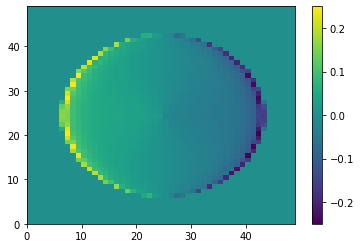

In [138]:
fig, ax = plt.subplots()
field = ax.pcolor((dhdx))
fig.colorbar(field, ax = ax)

In [ ]:
save_and_commit('./icecap.ipynb', 'icecap', 'icecap_iteration_out.nc', 'no great output, just to save friction inversion from radar')